In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import csv
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import random

In [2]:
# Make Reviews tsv file with business_id, stars, and text
outfile=open('review_stars.tsv', 'w')
sfile=csv.writer(outfile, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars','text']) #column titles

with open('yelp_dataset/yelp_academic_dataset_review.json', encoding="utf-8") as f:
    for line in f:
        row=json.loads(line)
        sfile.writerow([row['business_id'],row['stars'],(row['text']).encode('utf-8')])
outfile.close()

In [3]:
# Make business tsv file
outfile=open('business_stars.tsv', 'w')
sfile=csv.writer(outfile,delimiter='\t',quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','categories', 'name'])

with open('yelp_dataset/yelp_academic_dataset_business.json', encoding='utf-8') as f:
    for line in f:
        row = json.loads(line)
        if(row['review_count']>30):
            sfile.writerow([row['business_id'], row['categories'], (row['name']).encode('utf-8')])
outfile.close()

In [4]:
df_reviews=pd.read_csv('review_stars.tsv', sep='\t')
df_business=pd.read_csv('business_stars.tsv', sep='\t')
df_merged=pd.merge(df_reviews, df_business, on='business_id')
df_merged.to_csv('merged_df.tsv',sep='\t')
del df_reviews
del df_business
del df_merged

# Data Processing

In [2]:
df_merged=pd.read_csv('merged_df.tsv', sep='\t')

In [3]:
# Limiting number of reviews due to size
numEntries = 100000

In [4]:
vectorizer = sk_text.TfidfVectorizer(
                                    max_features=600,
                                    max_df=2000,
                                    min_df=1)
matrix=vectorizer.fit_transform(df_merged.text[0:numEntries])
tfidf_data=matrix.toarray()
del matrix

x = tfidf_data
y = df_merged.stars[0:numEntries]

## Finding Best Options

## Variation attempts
Layers:[20,20,20,20,1], activation:relu, RMSE: 0.9809  
Layers:[100,50,25,10,1], activation:relu, RMSE: 0.9976  
Layers:[20,20,1], activation:relu, RMSE: 0.9948  
Layers:[20,20,20,20,1], activation:tanh, RMSE: 0.9805  
Layers:[20,20,20,20,20,20,20,20,1], activation:tanh, RMSE: 0.9789 <- Best  
Layers:[20,20,20,20,20,20,20,20,1], activation:sigmoid, RMSE: 0.9890  
Layers:[20,20,20,1], activation:sigmoid, RMSE: 0.9879  
Layers:[100,50,20,1], activation:sigmoid, RMSE: 0.9879  
Layers:[20,20,20,20,20,20,20,20,1], activation:tanh, optimzer: sgd, RMSE: 0.9900


In [5]:
model = Sequential()

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, random_state=32)

model.add(Dense(20, input_dim=x.shape[1], activation='tanh')) 
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor,checkpointer], verbose=2, epochs=100)

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

2021-09-30 20:15:23.043978: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-30 20:15:23.044095: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alec-xps13): /proc/driver/nvidia/version does not exist
2021-09-30 20:15:23.047769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 20:15:23.709785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 180000000 exceeds 10% of free system memory.
2021-09-30 20:15:23.984257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (regi

Epoch 1/100


2021-09-30 20:15:25.563187: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.


2344/2344 - 2s - loss: 1.2145 - val_loss: 0.9944
Epoch 2/100
2344/2344 - 1s - loss: 0.9999 - val_loss: 0.9684
Epoch 3/100
2344/2344 - 1s - loss: 0.9860 - val_loss: 0.9877
Epoch 4/100
2344/2344 - 1s - loss: 0.9777 - val_loss: 0.9670
Epoch 5/100
2344/2344 - 1s - loss: 0.9712 - val_loss: 0.9666
Epoch 6/100
2344/2344 - 1s - loss: 0.9665 - val_loss: 0.9624
Epoch 7/100
2344/2344 - 1s - loss: 0.9593 - val_loss: 0.9777
Epoch 8/100
2344/2344 - 1s - loss: 0.9554 - val_loss: 0.9634
Epoch 00008: early stopping


In [6]:
pred=model.predict(x_test)

2021-09-30 20:15:35.600320: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 60000000 exceeds 10% of free system memory.


In [7]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final RMSE score: {:.4}".format(score))

Final RMSE score: 0.981


## Plotting regression

In [8]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.to_numpy()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

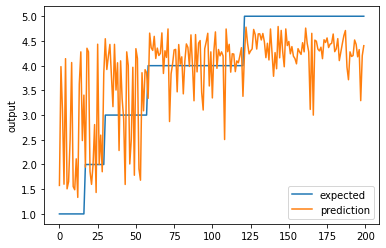

In [9]:
chart_regression(pred.flatten()[:200],y_test[:200],sort=True)

# Individual Business Predictions

In [10]:
df_unique_ids = df_merged.drop_duplicates(subset=['business_id']).reset_index()

In [11]:
def predict_single_business(id_num):
    df_single_business = df_merged[df_merged.business_id == id_num]
    vectorizer = sk_text.TfidfVectorizer(
                                    max_features=600,
                                    max_df=2000,
                                    min_df=1)
    matrix=vectorizer.fit_transform(df_single_business.text)
    tfidf_data=matrix.toarray()
    if(tfidf_data.shape[1] >= 500):
        return df_single_business.name[:1].to_string(index=False)[1:].strip("'").strip('"'), model.predict(tfidf_data).mean(), df_single_business.stars.mean()

In [12]:
def single_business_compare(numBusinesses):
    for i in range(numBusinesses):
        index = random.randint(0, df_unique_ids.shape[0])
        name, predicted, real = predict_single_business(df_unique_ids.business_id[index])
        print("{:30}: predicted score: {:3.1f}, real score: {:3.1f}".format(name, predicted, real))

In [13]:
single_business_compare(5)

Albasha Hookah Lounge         : predicted score: 3.5, real score: 4.8
Spice Market                  : predicted score: 3.4, real score: 2.8
The Arlington Restaurant & Diner: predicted score: 3.4, real score: 3.1
Bewell                        : predicted score: 3.4, real score: 4.5
The Comet Pub & Lanes         : predicted score: 3.7, real score: 2.9
